<div style='background-image: url("baku.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">8th Munich Earth Skience School</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)">Sudelfeld, 4-9 March 2018</div>
        </div>
    </div>


<p style="width:50%;float:right;padding-left:50px">
<img src=./mess.jpg>
<span style="font-size:smaller">
</span>
</p>

# 6-C polarization analysis using point measurements of translational and rotational ground-motion
## Exercise 3 Rayleigh-wave 

### Authors:
* David Sollberger (ETH Zurich)
* Cedric Schmelzbach (ETH Zurich)
* Cederic van Renterghem (ETH Zurich)
* Taufiqurrahman (LMU Munich)

***

In this notebook illustrate 6-C MUSIC algorithm using the example of a Rayleigh wave. A distinct maximum can be observed when a Rayleigh wave is present in the analysis window. At the free surface, the pure-mode polarization vectors v for a Rayleigh wave become (see Sollberger et.al.(2018) for details),

$$
{v_R} = 
\begin{pmatrix} 
jp_s \ sin \xi \ cos \phi \\
jp_s \ sin \xi \ sin \phi \\
-p_s \ cos \xi \\
\beta^{-1} \ cos \xi \ sin \phi \\
-\beta^{-1} \ cos \xi \ cos \phi \\
0
\end{pmatrix}
$$

Here, $j$ indicates that, for a Rayleigh wave, the horizontal components are phase-shifted by $π/2$ compared to the other components and $β$ is the local propagation velocity of the wave (since $k = ω/β$). Note that the polarization direction vector is frequency-independent, which means that polychromatic, transient events (e.g. seismic wavelets) also can be characterized by a single polarization direction, if dispersion effects (i.e. frequency-dependent $β$) are negligible.

From equation above, it is apparent that the free surface 6-C polarization vectors for a Rayleigh wave, respectively, can be fully described by the polarization parameter vectors: $m^R = (φ, ξ, β)^T$. We now seek to find the parameter vector $m$, that best describes the polarization vector for a specified wave type in an analysis window, even if there is interference of other waves.

For a given wave with wavefield parameter vector $m$, we define a likelihood function $L(d|m)$ : $\mathbb{R}^n$ → $\mathbb{R}^1$ (where $n$ is the number of elements in $m$) that maximizes when the parameters of m best describe the measured data $d$. The best-fitting parameter vector $m̂$ can then be found by a grid search through the solution space of $L(d|m)$:
$$
m̂ = arg max \ L(d|m)
$$

In order to define $L(d|m)$, we adapt the multiple signal classification algorithm (MUSIC) that was first introduced by Schmidt (1986). MUSIC is a very high-resolution signal detection approach and is widely used in radio direction finding and sonar. The algorithm explores the null-space of the coherency matrix C and yields accurate estimates of the model parameters. A major advantage of the MUSIC algorithm, is that it enables the detection of multiple interfering signals.

First, we perform an eigendecomposition of the 6 × 6 coherency matrix $C$. The six eigenvectors e n (for $n = 1, ..., 6$) of $C$ are then sorted in descending order of their eigenvalues such that $e_1$ is the eigenvector associated with the largest eigenvalue and $e_6$ the one associated with the smallest eigenvalue. We now define the null-space of the coherency matrix by taking the outer product of the minimum eigenvectors, yielding the following projection matrix:

$$Q(d) = (e_{6−l} · · · e_5 e_6 )(e_{6−l} · · · e_5 e_6 )^T$$

where $l$ is chosen with respect to the number of linearly polarized events that are to be resolved. We now define the MUSIC likelihood function as (Schmidt 1986):

$$
L(d|m) = \frac{1}{v̂^T(m)Q(d)v̂(m)}
$$

where $v̂(m)$ describes the 6-C polarization of a pure-state wave arrival of a specified mode of vibration as given by the polarization models in previous equations, normalized to a unit vector $(v̂ = \frac{v}{||v||})$. Due to the nonlinearity of the function $L(d|m)$, it is very sensitive to the global maximum.

In [1]:
# import libraries 
# ----------------
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from ricker     import *
from awgn       import *
from polvect6C  import *
from music6C    import *

class structtype():
    pass

In [2]:
# MUSIC parameters 
# ----------------
test_param     = structtype()
test_param.vR  = np.arange(100,300+10,10)          # parameter space for vR
test_param.phi = np.arange(-180,180+1,1)           # parameter space for phi
test_param.xi  = np.linspace(-np.pi/2,np.pi/2,100) # parameter space for xi
wl = 0.5                                           # window length in seconds

# wave parameters
xi     = np.pi/8.        # ellipticity [degree]
phi    = 0.              # azimuth [degree]
vR     = 200             # Rayleigh wave velocity [m/s]
v_scal = 1.5 * vR        # scaling velocity (slightly overestimated S-wave velocity)
w      = 6. * np.pi * 1. # frequency of the wave
alpha  = 1.              # maximum displacement amplitude of the wave
pha    = 0.              # phase of the wave

# seismogram parameters
tmin = 0.                         # minimum time of the seismogram [s]
tmax = 2.                         # maximum time of the seismogram [s]
dt   = 0.01                       # sampling interval [s]
t    = np.arange(tmin,tmax+dt,dt) # time [s]

# generate synthetic, plane Rayleigh wave
deg = 1/180.*np.pi # convert degree to radian
v_x =  w / v_scal * alpha * np.sin(xi) * np.cos(phi*deg)*np.sin(w*t+pha) # translational x-component
v_y =  w / v_scal * alpha * np.sin(xi) * np.sin(phi*deg)*np.sin(w*t+pha) # translational y-component
v_z = -w / v_scal * alpha * np.cos(xi) * np.cos(w*t+pha)                 # translational z-component

w_x =  alpha * (w/vR) * np.sin(phi*deg) * np.cos(xi) * np.cos(w*t+pha)   # rotational x-component
w_y = -alpha * (w/vR) * np.cos(phi*deg) * np.cos(xi) * np.cos(w*t+pha)   # rotational y-component
w_z = 0. * w_x                                                           # rotational z-component

data = np.matrix.getH(np.asarray([v_x,v_y,v_z,w_x,w_y,w_z]))

# add random noise 
SNR  = 50.                        # signal to noise ratio
data = awgn(data,SNR)

In [3]:
# 6-C MUSIC 
# ---------
W = (wl / dt) # window length in samples
L = music6C(data,test_param,'R',v_scal,0.5/dt,W,'auto',0,0.01)

In [4]:
# remove instabilities 
# --------------------
L_ = np.nan_to_num(L)
L_[L_ < 0.] = 1.

# determine maximum value and index of the MUSIC estimator 
maxval =    np.max((L_[:]))
maxidx = np.argmax((L_[:]))
i,j,k  = np.unravel_index(maxidx, L_[:].shape) # column- to row-major indexing

phixi  = np.squeeze(((L_[:,:,k]))) # plane through best-fitting velocity parameters

<IPython.core.display.Javascript object>


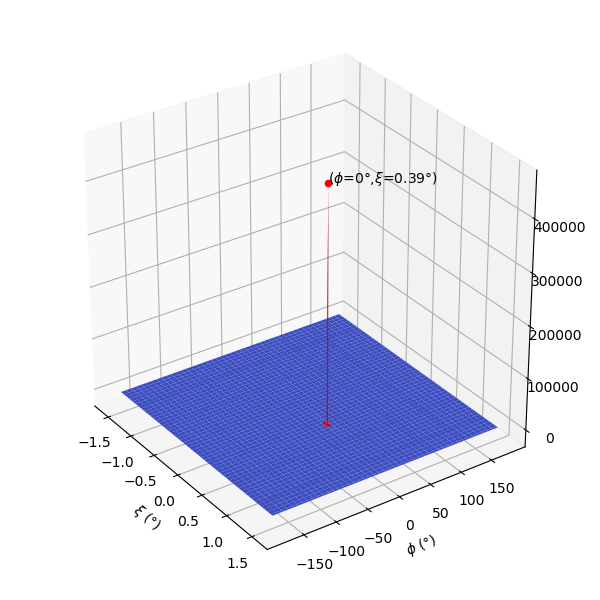

In [5]:
# plot configuration 
# ------------------
fig = plt.figure(figsize=(6, 6))
ax  = fig.gca(projection='3d')

X = test_param.phi
Y = test_param.xi
X,Y = np.meshgrid(Y,X)
Z = phixi

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.set_ylabel(r'$\phi$ (°)')
ax.set_xlabel(r'$\xi$ (°)')
ax.scatter(xi,phi,np.max(phixi),c='r')
ax.view_init(elev=30., azim=-35)
ax.text(xi, phi, np.max(phixi), r'($\phi$={}°,$\xi$={}°)'.format(int(phi),np.round(xi,2)), color='black')

# show result on screen
plt.tight_layout()
plt.show()